In [1]:
image_size = 512
backbone='tf_efficientdet_lite0'

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms

# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold


# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_axial_images_jpeg95')

In [4]:
boundary_df = pd.read_csv(os.path.join(DATA_DIR, 'train_axial_boundary.csv')).set_index('UID')
print(len(boundary_df))
boundary_df.head()

2012


,aspect,xmin,ymin,xmax,ymax
UID,,,,,
1.2.826.0.1.3680043.10001,2.461541,78.849180,47.024193,453.30298,420.97748
1.2.826.0.1.3680043.10005,2.091504,93.988910,63.075333,373.98172,460.40836
1.2.826.0.1.3680043.10014,3.418803,22.234573,11.231842,500.32007,506.54834
1.2.826.0.1.3680043.10016,1.136566,73.564575,27.175400,444.91382,438.84436
1.2.826.0.1.3680043.10032,1.951216,85.200000,30.145882,420.28073,443.24400


In [5]:
def square_crop_position(crop_box, image_size=512):
    """
    crop box 를 정방형으로 만들어준다.
    :param left:
    :param top:
    :param right:
    :param bottom:
    :param image_size:
    :return:
    """
    left, top, right, bottom = crop_box
    w, h = right - left, bottom - top

    if h > w:
        left_pad = (h - w) // 2
        right_pad = h - w - left_pad
        left -= left_pad
        right += right_pad

        if left < 0:
            right -= left
            left = 0
        elif right > image_size:
            left -= right - image_size
            right = image_size
    else:
        top_pad = (w - h) // 2
        bottom_pad = w - h - top_pad
        top -= top_pad
        bottom += bottom_pad

        if top < 0:
            bottom -= top
            top = 0
        elif bottom > image_size:
            top -= bottom - image_size
            bottom = image_size
    return left, top, right, bottom


square_crop_position([0, 1, 2, 4], image_size=5)

(0, 1, 3, 4)

In [6]:
for i in range(len(boundary_df)):
    boundary = boundary_df.iloc[i]
    boundary_df.loc[boundary.name, ['xmin','ymin','xmax','ymax']] = square_crop_position(boundary[['xmin','ymin','xmax','ymax']].values, image_size)
print(len(boundary_df))
boundary_df.head()

2012


,aspect,xmin,ymin,xmax,ymax
UID,,,,,
1.2.826.0.1.3680043.10001,2.461541,78.849180,47.024193,453.302980,421.477993
1.2.826.0.1.3680043.10005,2.091504,35.988910,63.075333,433.321937,460.408360
1.2.826.0.1.3680043.10014,3.418803,14.234573,11.231842,509.551071,506.548340
1.2.826.0.1.3680043.10016,1.136566,53.564575,27.175400,465.233535,438.844360
1.2.826.0.1.3680043.10032,1.951216,46.200000,30.145882,459.298118,443.244000


In [7]:
def get_image_and_labels_by_idx(image_dir, boundary_df, UID, slice):

    r = Image.open(os.path.join(image_dir, UID, f"{slice - 1}.jpeg"))
    g = Image.open(os.path.join(image_dir, UID, f"{slice - 0}.jpeg"))
    b = Image.open(os.path.join(image_dir, UID, f"{slice + 1}.jpeg"))
    img = Image.merge('RGB', (r, g, b))

    s = boundary_df.loc[UID]

    crop_box = s[['xmin', 'ymin', 'xmax', 'ymax']].values
    return img, crop_box

In [15]:
def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ]
    )
transform = get_valid_transforms()


## Model

In [9]:
from effdet import create_model
model = create_model(backbone , bench_task='predict' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True)
model = model.to(device)

In [37]:
state = torch.load(os.path.join(DATA_DIR, 'checkpoint','axial_detection_effdet_210507-epoch-54.pth'))
model.load_state_dict(state["model"])

<All keys matched successfully>

[tensor([318.7674, 138.9420, 418.7167, 231.9514,   0.9540], device='cuda:0')]


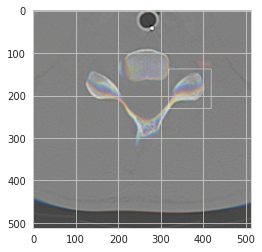

In [79]:
from torchvision.utils import draw_bounding_boxes
def infer_slice(UID, slice):
    image, crop_box = get_image_and_labels_by_idx(IMAGES_DIR, boundary_df, UID, slice)
    image = image.crop(crop_box)
    transformed = transform(image=np.array(image, dtype=np.float32))
    image = transformed["image"]

    bboxes = model(image.to(device).unsqueeze(0))[0]

    image = (image * 0.5 + 0.5) * 255
    image = image.to(torch.uint8)
    print(list(bboxes[:1, :5]))
    bbox_image = draw_bounding_boxes(image, boxes=bboxes[:1, :4], colors='white')
    plt.imshow(bbox_image.permute(1, 2, 0).cpu().numpy(), cmap='bone')

with torch.no_grad():
    infer_slice('1.2.826.0.1.3680043.9290', 140)

In [80]:
infer_result = []

def read_batch_image(UID, slice, batch_size):
    image_list = []
    for i in range(batch_size):
        image, crop_box = get_image_and_labels_by_idx(IMAGES_DIR, boundary_df, UID, slice + i)
        image = image.crop(crop_box)
        transformed = transform(image=np.array(image, dtype=np.float32))
        image = transformed["image"]
        image_list.append(image)
    return torch.stack(image_list, dim=0)

def infer_patient_axial(UID):
    image_paths = glob.glob(os.path.join(IMAGES_DIR, UID) + '/*.jpeg')

    slice = 1
    end_slice = len(image_paths) - 2

    batch_size = 16

    bboxes_list = []

    for i in tqdm(range(math.ceil((end_slice-1) / batch_size))):
        batch_size = min(end_slice - slice, batch_size)
        images = read_batch_image(UID, slice, batch_size)
        images = images.to(device)
        bboxes = model(images)

        bboxes_list.extend(bboxes[:, 0, 4].cpu().numpy())
        slice += batch_size

    return bboxes_list

with torch.no_grad():
    model.eval()
    bboxes_list = infer_patient_axial('1.2.826.0.1.3680043.9290')

100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


In [81]:
bboxes_list

[0.26666042,
 0.18525615,
 0.28306794,
 0.034302976,
 0.04039357,
 0.41423368,
 0.82786345,
 0.96968746,
 0.7651389,
 0.7006036,
 0.42061853,
 0.07056831,
 0.33318472,
 0.042143542,
 0.9831669,
 0.9875656,
 0.99915934,
 0.8714007,
 0.92263293,
 0.9861509,
 0.9653094,
 0.99317557,
 0.5962652,
 0.9458556,
 0.9118804,
 0.495756,
 0.3256072,
 0.8840739,
 0.9511339,
 0.9936458,
 0.9453652,
 0.7496716,
 0.6177356,
 0.13738324,
 0.53175795,
 0.16095622,
 0.8411626,
 0.97001654,
 0.2995817,
 0.06666227,
 0.3489091,
 0.06847083,
 0.39358658,
 0.41285792,
 0.7537456,
 0.03428659,
 0.079230286,
 0.10837237,
 0.7334371,
 0.9987876,
 0.9999902,
 0.99928397,
 0.81301486,
 0.37291837,
 0.7149944,
 0.61685556,
 0.17406733,
 0.7396531,
 0.09903022,
 0.9571202,
 0.7382859,
 0.045416344,
 0.04026206,
 0.16557553,
 0.21391945,
 0.20547558,
 0.07617272,
 0.1885775,
 0.22644258,
 0.17393582,
 0.69647473,
 0.90049356,
 0.27384305,
 0.07904643,
 0.55777943,
 0.13462599,
 0.1168988,
 0.8982504,
 0.20013744,
 0

In [67]:
bboxes_list[96:105]

[0.9973579,
 0.9902327,
 0.9178026,
 0.50512666,
 0.9980142,
 0.90014,
 0.6976765,
 0.9242573,
 0.9929704]

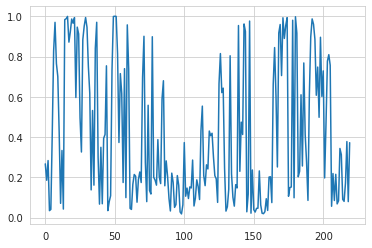

In [82]:
plt.plot(bboxes_list)